(continuous_hgf)=
# The continuous Hirarchical Gaussian Filter

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ghgf import load_data
from ghgf.model import HGF

In this example, we will use the exchange rate of the US Dollar to the Swiss Franc during much of 2010 and 2011 as a time series that the Hierarchical Gaussian Filter is going to predict.

## Data import

In [3]:
timeserie = load_data("continuous")

In [4]:
# Format the data input accordingly (a value column and a time column)
input_data = np.array(
    [
        timeserie, 
        np.arange(1, len(timeserie) + 1, dtype=float)]
).T

In [5]:
input_data

array([[  1.0357,   1.    ],
       [  1.0319,   2.    ],
       [  1.0359,   3.    ],
       ...,
       [  0.7889, 612.    ],
       [  0.7876, 613.    ],
       [  0.8241, 614.    ]])

## Using a two-levels model

In [7]:
two_levels_hgf = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mu={"1": 1.04, "2": 1.0},
    initial_pi={"1": 1e4, "2": 1e1},
    omega={"1": -13.0, "2": -6.0},
    rho={"1": 0.0, "2": 0.0},
    kappas={"1": 1.0}).input_data(
        input_data=input_data
    )

Creating a continuous Hierarchical Gaussian Filter with 2 levels (JAX backend).
Add 614 new continuous observations.


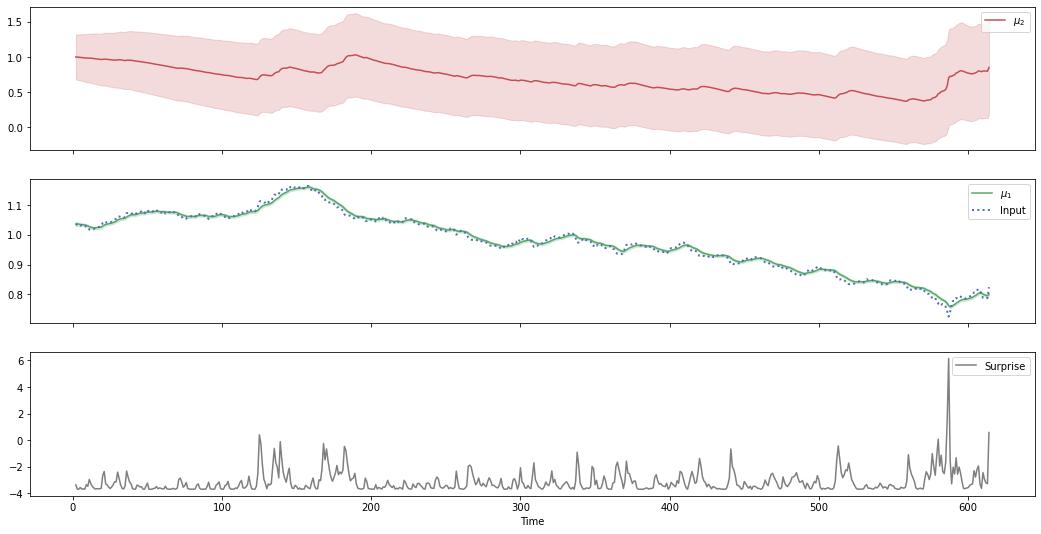

In [8]:
two_levels_hgf.plot_trajectories()

We can see that the surprise will increase when the time series exhibit more unexpected behaviors. The degree to which a given observation is expected will deppends on the expeted value and volatility in the input node, that are influenced by the values of higher order nodes. One way to assess model fit is to look at the total gaussian surprise for each observation. This values can be returned using the `surprise` method:

In [9]:
two_levels_hgf.surprise()

DeviceArray(-1921.5396, dtype=float32)

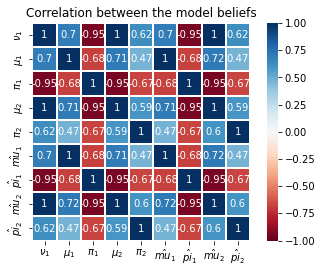

In [10]:
two_levels_hgf.plot_correlations()

The model fit will directly be influenced by the model parameters. One important parameters for each node is $\omega$ (`omega`). This is the tonic part of the variance (the part of the variance in each node that is not affected by the parent node). Here we are going to change $\omega$ for both the first and the second level:

In [12]:
hgf_high_omega = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mu={"1": 1.04, "2": 1.0},
    initial_pi={"1": 1e4, "2": 1e1},
    omega={"1": -2.0, "2": -1.0},
    rho={"1": 0.0, "2": 0.0},
    kappas={"1": 1.0}).input_data(
        input_data=input_data
    )

Creating a continuous Hierarchical Gaussian Filter with 2 levels (JAX backend).
Add 614 new continuous observations.


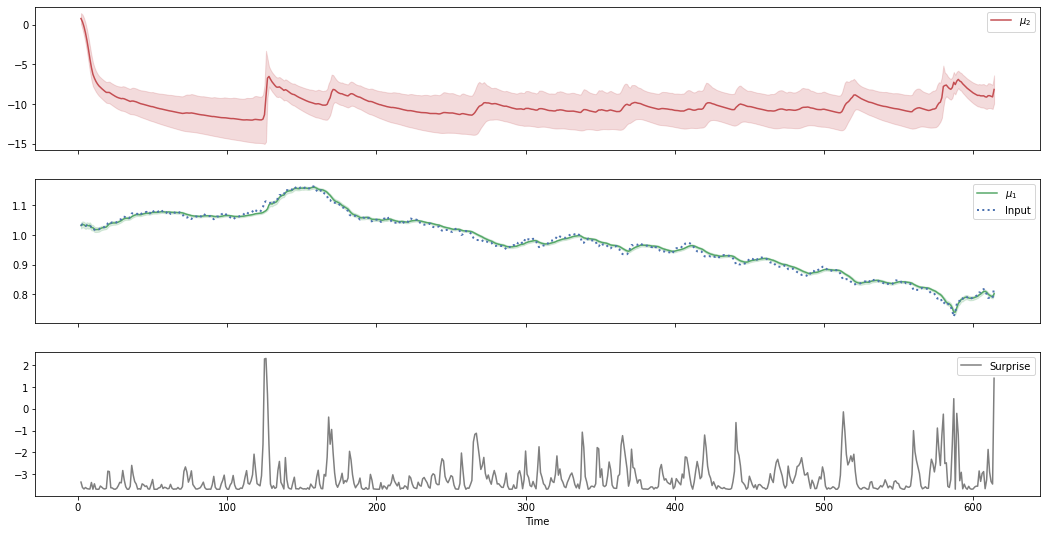

In [13]:
hgf_high_omega.plot_trajectories()

In [14]:
hgf_high_omega.surprise()

DeviceArray(-1947.0228, dtype=float32)

## Using a three-level model
### Create the model

In [28]:
three_levels_hgf = HGF(
    n_levels=3,
    model_type="continuous",
    initial_mu={"1": 1.04, "2": 1.0, "3": 1.0},
    initial_pi={"1": 1e4, "2": 1e1, "3": 1e1},
    omega={"1": -13.0, "2": -6.0, "3": -2.0},
    rho={"1": 0.0, "2": 0.0, "3": 0.0},
    kappas={"1": 1.0, "2": 1.0})

Creating a continuous Hierarchical Gaussian Filter with 3 levels (JAX backend).


### Add data

In [29]:
# Provide new observations
three_levels_hgf.input_data(input_data=input_data)

Add 614 new continuous observations.


### Plot trajectories

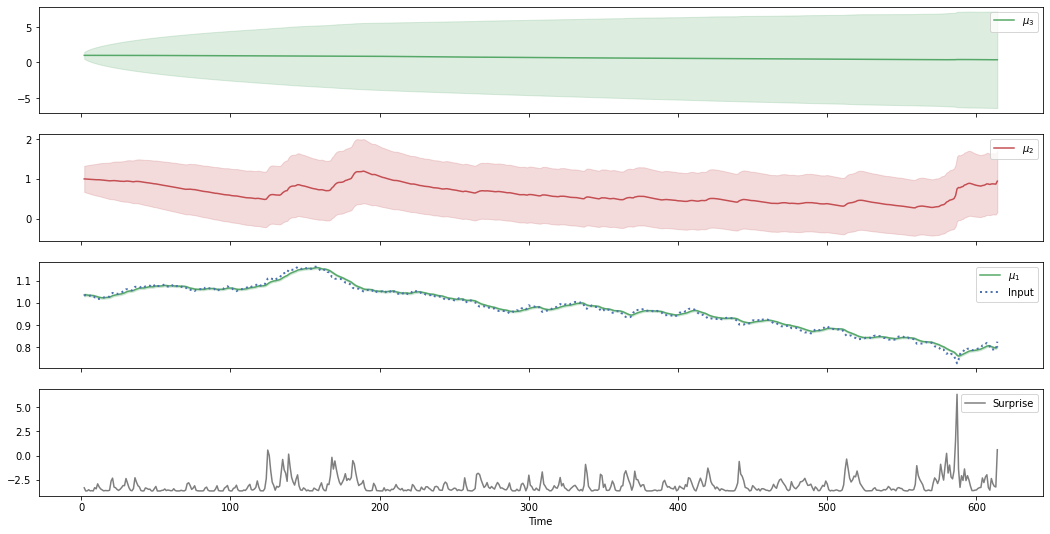

In [30]:
three_levels_hgf.plot_trajectories()

## Surprise minimization

The variety of parameters that are embedded in the Hierarchical Gaussian Filter can all influence the model fit, here measured using the gaussian surprise. One key question is then to estimate the parameters values that are more likely to minimise surprise, given the observations already made by the model. Because the HGF models we use here are all written in [JAX](https://github.com/google/jax), it is straightforward to embed this code into a computational graph, such as the ones build by [Aesara](https://aesara.readthedocs.io/en/latest/) in order to use MCMC sampling (e.g. NUST) to estimate the probability density for each of our parameters of interest. Here, we are going to use [PyMC](https://www.pymc.io/welcome.html) to perform this step.

In [15]:
import pymc as pm
import arviz as az
from ghgf.pymc import HGFDistribution
from ghgf.response import gaussian_surprise

We first import the `HGFDistribution`, that encapsulate a custom log_probability function of the HG (and its gradient). We also load the `gaussian_surprise` function from the `response` module. This function define how the agent is getting its insight on the model fit (here the surprise simply comes from observing a new value).

In [16]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    data=input_data,
    response_function=gaussian_surprise,
    response_function_parameters=(np.array(1), 1),
)

This log probabilit function can then be embedded in a PyMC model using the same API. Here, we only want to let `omega_1` and `omega_2` vary, the other parameters are fixed.

In [17]:
with pm.Model() as two_level_hgf:

    omega_1 = pm.Normal("omega_1", -6.0, 2)
    omega_2 = pm.Normal("omega_2", -6.0, 2)

    pm.Potential(
        "hhgf_loglike",
        hgf_logp_op(
            omega_1=omega_1,
            omega_2=omega_2,
            omega_input=np.log(1e-4),
            rho_1=np.array(0.0),
            rho_2=np.array(0.0),
            pi_1=np.array(1e4),
            pi_2=np.array(1e1),
            mu_1=np.array(input_data[0, 0]),
            mu_2=np.array(0.0),
            kappa_1=np.array(1.0),
            bias=np.array(0.0),
        ),
    )

In [18]:
with two_level_hgf:
    two_level_hgf_idata = pm.sample(chains=4)

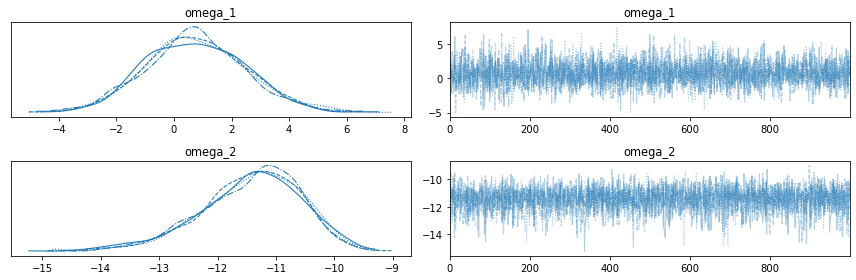

In [19]:
az.plot_trace(two_level_hgf_idata, var_names=["omega_1", "omega_2"]);
plt.tight_layout()

We can see that the most probables values are not exactly the ones we tried in the first instance. We can then refit a new model from scratch using the most probable ones.

In [20]:
omega_1 = az.summary(two_level_hgf_idata)["mean"]["omega_1"]
omega_2 = az.summary(two_level_hgf_idata)["mean"]["omega_2"]

In [22]:
hgf_mcmc = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mu={"1": 1.04, "2": 1.0},
    initial_pi={"1": 1e4, "2": 1e1},
    omega={"1": omega_1, "2": omega_2},
    rho={"1": 0.0, "2": 0.0},
    kappas={"1": 1.0}).input_data(
        input_data=input_data
    )

Creating a continuous Hierarchical Gaussian Filter with 2 levels (JAX backend).
Add 614 new continuous observations.


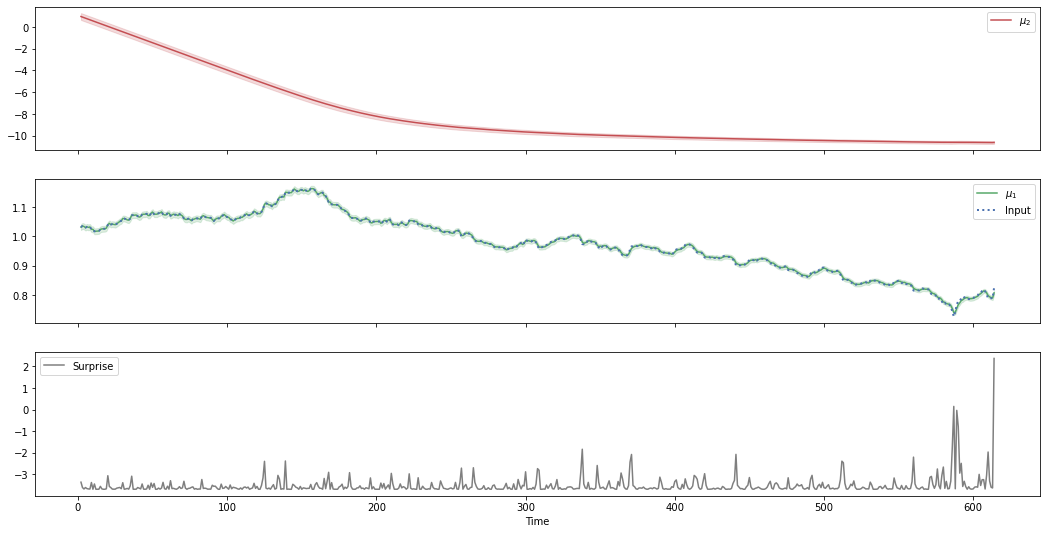

In [23]:
hgf_mcmc.plot_trajectories()

In [24]:
hgf_mcmc.surprise()

DeviceArray(-2152.1733, dtype=float32)

Looking at the volatility (ie, the second) level, we see that there are two salient events in our time series where volatility shoots up. The first is in April 2010 when the currency markets react to the news that Greece is effectively broke. This leads to a flight into the US dollar (green dots rising very quickly), sending the volatility higher. The second is an accelarating increase in the value of the Swiss Franc in Augutst and September 2011, as the Euro crisis drags on. The point where the Swiss central bank intervened and put a floor under how far the Euro could fall with respect to the Franc is clearly visible in the Franc's valuation against the dollar. This surprising intervention shows up as another spike in volatitlity.